# Analysis of Tina simulation results

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import warnings

import os
import sys
import glob

from matplotlib import rc
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as patches

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8.0, 5.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
from IPython.display import display, Markdown

sim_path = '../data/raw/varying-R3'
sim_param = 'R3'
R3_values = np.array([[22, 47, 100, 300]]) * 1e3

mdfile = sim_path + '/Readme.md'

with open(mdfile, 'r') as fh:
    content = fh.read()

display(Markdown(content))

### Parameters

| **Parameter**  | **Value**                |
|----------------|--------------------------|
| Op-amp (s2/s3) | OPA333                   |
| Vcc            | 3.3 V                    |
| Vee            | 0.0 V                    |
| R3             | 22, 47, 100 and 300 kOhm |
| R4             | 10 MOhm                  |
| R5             | 1 KOhm                   |
| C2             | 5 uF                     |
| Vo1 (DC Level) | 1.65                     |
| Vo1 (Signal)   | Synthetic_signal         |
| Vo1 (A)        | 0.8V                     |
| Vo1 (f)        | NA                       |


### Data files

Data files format is .txt. Data files have a one-line header (first row) starting with the character *. Data follow. Columns are separated by '\t'.

Example: 

---
*Time 	vo1_phi[1]	vo1[1]	vo3[1]	vo2[1]

0	1.65000000219073	1.65362369158755	1.65000240451935	3.29997962313781

0.025	1.78036203802659	1.80971446653372	1.78009762006678	3.29998157908571

0.0287138182481702	1.80127776044844	1.83266661394274	1.80099169507382	3.29998186497682

0.0361414547445107	1.84493219384149	1.87826600650275	1.84462490147006	3.2999824303021

---

Each data file contains the following columns:
* Column 1: Time (s)
* Column 2: vo1_phi - Input signal of U3 ($v^{\phi}_{o1}$) (V)
* Column 3: vo1 - Input signal at non-inverting terminal of U2 ($v_{o1}$) (V)
* Column 4: vo3 - Ouput signal of U3 ($v_{o2}$) (V)
* Column 5: vo2 - Ouput signal of U2 ($v_{o3}$) (V)

## Load simulation datafiles

We will load the simulation files and format/store the data for later analysis. We will create a dictionary where keys are the simulated resistor ($R_{3}$) and the content is a Pandas dataframe with the data from each file.

In [3]:
def load_sim_files(sim_path, sim_param, verbose=False):
    # Get simulation filenames
    filename = sim_path + '/tcurve-%s.txt'%(sim_param)
    
    if not filename:
        raise ValueError("File %s does not exist" % (filename))
    
    sim_database = load_tina_single_datafile(filename, verbose=verbose)

    # Return dictionary with all files data and sim_param
    return sim_database

def load_tina_single_datafile(filename, verbose=False):
    # Create empty dictionary
    dout = dict()
    # Check filepath
    if not os.path.isfile(filename):
        print("File path {} does not exist. Exiting...".format(filename))
        sys.exit()
    if verbose == True:
        print("Processing %s..." % (filename))
    # Read file
    with open(filename) as fp:
        freq = None
        for line in fp:
            line_contents = line.strip().split('\t')
            if len(line_contents) != 5: 
                continue
            if '*' in line_contents[0]:
                # Remove '*' character from '*Time'
                line_contents[0] = line_contents[0][1:]
                # Extract frequency
                rindex = str(int(line_contents[1].split('[')[1].split(']')[0]))
                # Add to dictionary
                if rindex not in dout:
                    dout[rindex] = pd.DataFrame(columns=line_contents)
                    if verbose == True: 
                        print("  Added rindex=%s to dictionary"%(rindex))
                else:
                    warnings.warn("Warning...........[read_single_file] key %s already exists" % (rindex))
            else:
                if rindex is not None:
                    #values = ([float(i) for i in line_contents])
                    dout[rindex] = dout[rindex].append(pd.Series(line_contents,
                                                                 index=dout[rindex].columns.values.tolist()),
                                                       ignore_index=True)
                else:
                    raise ValueError('Dataframe not created in dictionary')
    for r in dout:
        # Convert all columns of each dataframe in d to float64
        dout[r] = dout[r].apply(pd.to_numeric)
        dout[r] = dout[r].rename(
            columns={dout[r].columns.values[0]: "timestamp", 
                     "vo1_phi[%s]"%(r): "vo1_phi",
                     "vo1[%s]"%(r): "vo1",
                     "vo2[%s]"%(r): "vo2",
                     "vo3[%s]"%(r): "vo3"}
                      )
        dout[r] = dout[r].set_index('timestamp')
    # Get frequencies
    sim_rindex = np.sort(np.fromiter(dout.keys(), dtype=int))
    # Return dataframe
    return { 'sim_database': dout, 'sim_rindex': sim_rindex }

def plot_dataset(dataset):
    
    x = dataset.index.values
    vo1 = dataset['vo1'].values
    vo1_phi = dataset['vo1_phi'].values
    vo2 = dataset['vo2'].values
    vo3 = dataset['vo3'].values
    
    # Create figure and axes
    fig = plt.figure(figsize=(8.0, 5.0))
    ax0 = fig.add_subplot(111)
    # Plot
    ax0.plot(x, vo1, label=r'$v_{o1}$', color=colors['saddlebrown'])
    ax0.plot(x, vo2, label=r'$v_{o2}$', color=colors['red'])
    ax0.plot(x, vo1_phi, label=r'$v^{\phi}_{o1}$', color=colors['goldenrod'])
    ax0.plot(x, vo3, label=r'$v_{o3}$', color=colors['darkolivegreen'])
    ncol = 3
        
    # Grid    
    ax0.grid(color='gray', linestyle='dotted')
    # Legend
    ax0.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=ncol,
            borderaxespad=0, frameon=True)
    
    # Axes labels
    ax0.set_ylabel('Voltage (V)')
    ax0.set_xlabel('Time (s)')
    
    # Some cosmetics
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.yaxis.set_ticks_position('left')
    ax0.xaxis.set_ticks_position('bottom')

    # Adjust plot to plotting area
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Main code

In [4]:
sim_data = load_sim_files(sim_path, sim_param, verbose=True)

Processing ../data/raw/varying-R3/tcurve-R3.txt...
  Added rindex=1 to dictionary
  Added rindex=2 to dictionary
  Added rindex=3 to dictionary
  Added rindex=4 to dictionary


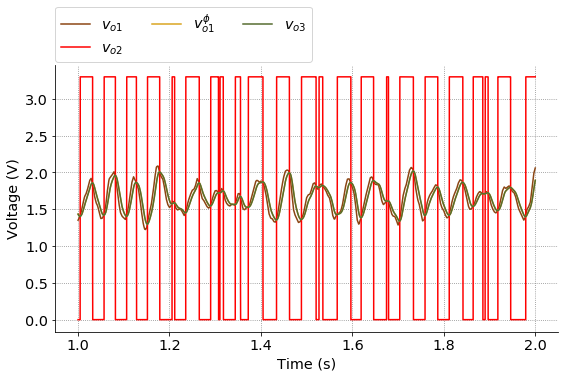

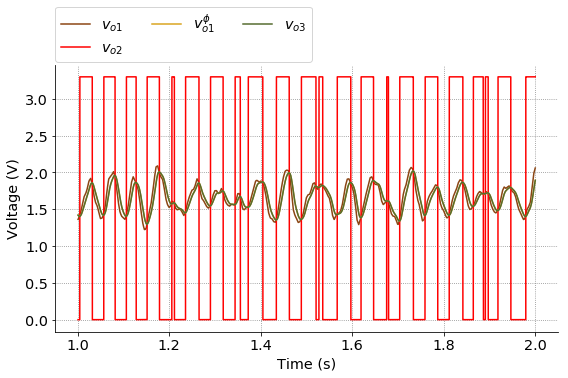

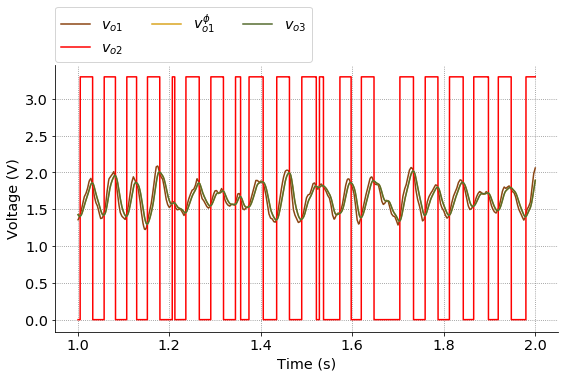

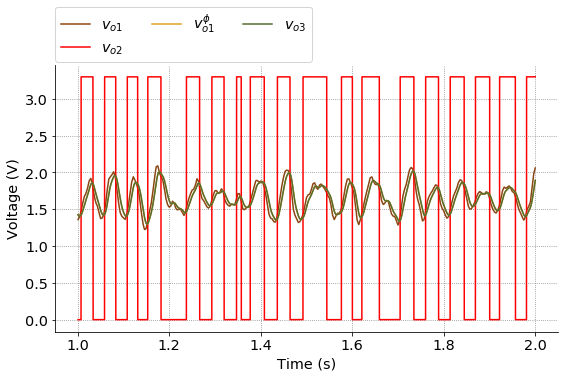

In [5]:
database = sim_data['sim_database']
rindex = sim_data['sim_rindex']
# Preprocess data
for r in rindex:
    # Get dataframe with data
    df = sim_data['sim_database'][str(r)]
    plot_dataset(df)

In [6]:
vo1 = sim_data['sim_database'][str(rindex[0])]['vo1']
vo2_r22 = sim_data['sim_database'][str(rindex[0])]['vo2']
vo2_r47 = sim_data['sim_database'][str(rindex[1])]['vo2']
vo2_r100 = sim_data['sim_database'][str(rindex[2])]['vo2']
vo2_r300 = sim_data['sim_database'][str(rindex[3])]['vo2']

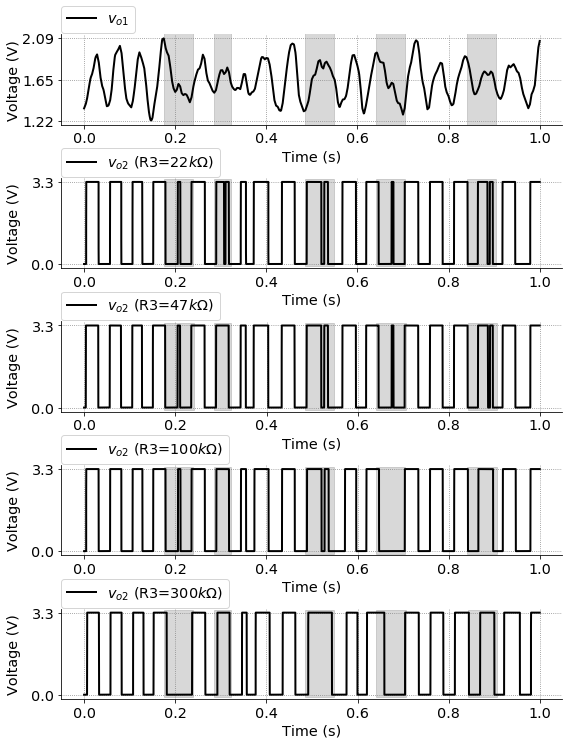

In [7]:
fig = plt.figure(figsize=(8.0, 11.0))
ax0 = fig.add_subplot(511)
ax1 = fig.add_subplot(512)
ax2 = fig.add_subplot(513)
ax3 = fig.add_subplot(514)
ax4 = fig.add_subplot(515)

x0 = vo1.index.values - vo1.index.values[0]
x1 = vo2_r22.index.values - vo2_r22.index.values[0]
x2 = vo2_r47.index.values - vo2_r47.index.values[0]
x3 = vo2_r100.index.values - vo2_r100.index.values[0]
x4 = vo2_r300.index.values - vo2_r300.index.values[0]

y0 = vo1.values
y1 = vo2_r22.values
y2 = vo2_r47.values
y3 = vo2_r100.values
y4 = vo2_r300.values

ax0.plot(x0, y0, lw=2, label= r'$v_{o1}$', color='k')
ax1.plot(x1, y1, lw=2, label= r'$v_{o2}$ (R3=22$k\Omega$)', color='k')
ax2.plot(x2, y2, lw=2, label= r'$v_{o2}$ (R3=47$k\Omega$)', color='k')
ax3.plot(x3, y3, lw=2, label= r'$v_{o2}$ (R3=100$k\Omega$)', color='k')
ax4.plot(x4, y4, lw=2, label= r'$v_{o2}$ (R3=300$k\Omega$)', color='k')

for ax in (ax0, ax1, ax2, ax3, ax4):
    rect0 = patches.Rectangle((0.175,-0.1),.065,3.5, color=colors['gray'],alpha=0.3)
    rect1 = patches.Rectangle((0.285,-0.1),.038,3.5, color=colors['gray'],alpha=0.3)
    rect2 = patches.Rectangle((0.485,-0.1),.064,3.5, color=colors['gray'],alpha=0.3)
    rect3 = patches.Rectangle((0.641,-0.1),.064,3.5, color=colors['gray'],alpha=0.3)
    rect4 = patches.Rectangle((0.841,-0.1),.064,3.5, color=colors['gray'],alpha=0.3)
    
    ax.add_patch(rect0)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)

for ax in (ax0, ax1, ax2, ax3, ax4):
    ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel(r'Time (s)')
    ax.grid(color='gray', linestyle='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.get_yaxis().set_label_coords(-0.08,0.5)
    
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
                   borderaxespad=0, frameon=True)

ax0.set_yticks([round(np.min(y0),2), 1.65, round(np.max(y0), 2)])
for ax in (ax1, ax2, ax3, ax4):
    ax.set_yticks([0.0, 3.3])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if not os.path.exists('figures'):
    os.makedirs('figures')
figurename = 'figures/figure06.pdf'
plt.savefig(figurename, transparent=True, format='pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0)